## English to Indonesian translation using attention

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import os
from nltk.translate.bleu_score import sentence_bleu
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

# Loss function: https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_cuda = torch.cuda.is_available()

In [3]:
import pandas as pd
from gensim.corpora.dictionary import Dictionary
from nltk import word_tokenize

In [4]:
fp = open('./corpus/eng-indo.txt', 'r')
text = fp.read()
text = text.splitlines()
fp.close()

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


text_dict = {"English": [], "Indonesian": []}
for l in text:
    split_text = l.split("\t")
    text_dict["English"].append(normalizeString(split_text[0]))
    text_dict["Indonesian"].append(normalizeString(split_text[1]))
    
df = pd.DataFrame.from_dict(text_dict)
print(df.shape)
df.head()

(6752, 2)


,English,Indonesian
0,run !,lari !
1,who ?,siapa ?
2,wow !,wow !
3,help !,tolong !
4,jump !,lompat !


In [5]:
MAX_LENGTH = 15
MIN_LENGTH = 4

In [6]:
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re ",
    "tom is", "tom s",
    "what s", "what a",
   "are you", "do you",
   "what is", "tom was",
   "don t", "it s", "where s",
   "where did", "where is",
)

def should_keep_row(row):
    """ Should the current row be kept as training set"""
    # indo_num_words = len(word_tokenize(row["Indonesian"]))
    eng_num_words = len(word_tokenize(row["English"]))
    max_words_required = MAX_LENGTH - 2
    min_words_required = MIN_LENGTH

    return eng_num_words <= max_words_required

df["keep_row"] = df.apply(should_keep_row, axis=1)
print(df.shape)
df.head()

print("Current shape: " + str(df.shape))
df = df[df["keep_row"]]
print("New shape: " + str(df.shape))
df.head()
df = df.reset_index().drop(columns=["keep_row"])
df.head()

(6752, 3)
Current shape: (6752, 3)
New shape: (6578, 3)


,index,English,Indonesian
0,0,run !,lari !
1,1,who ?,siapa ?
2,2,wow !,wow !
3,3,help !,tolong !
4,4,jump !,lompat !


In [7]:
# Use a unique string to indicate START and END of a sentence.
# Assign a unique index to them.
START, START_IDX = '<s>',  0
END, END_IDX = '</s>', 1
UNK, UNK_IDX = 'UNK', 2

SOS_token = START_IDX
EOS_token = END_IDX

# We use this idiom to tokenize our sentences in the dataframe column:
# >>> DataFrame['column'].apply(str.lower).apply(word_tokenize)

# Also we added the START and the END symbol to the sentences. 
english_sents = [START] + df['English'].apply(str.lower).apply(word_tokenize) + [END]
indo_sents = [START] + df['Indonesian'].apply(str.lower).apply(word_tokenize) + [END]

# We're sort of getting into the data into the shape we want. 
# But now it's still too humanly readable and redundant.
## Cut-away: Computers like it to be simpler, more concise. -_-|||
print('First English sentence:', english_sents[0])
print('First Indo sentence:', indo_sents[0])

english_vocab = Dictionary([['<s>'], ['</s>'],['UNK']])
english_vocab.add_documents(english_sents)

indo_vocab = Dictionary([['<s>'], ['</s>'], ['UNK']])
indo_vocab.add_documents(indo_sents)

# First ten words in the vocabulary.
print('First 10 Indonesian words in Dictionary:\n', sorted(indo_vocab.items())[:10])
print()
print('First 10 English words in Dictionary:\n', sorted(english_vocab.items())[:10])

english_vocab = Dictionary([['<s>'], ['</s>'],['UNK']])
english_vocab.add_documents(english_sents)

indo_vocab = Dictionary([['<s>'], ['</s>'], ['UNK']])
indo_vocab.add_documents(indo_sents)

# First ten words in the vocabulary.
print('First 10 Indonesian words in Dictionary:\n', sorted(indo_vocab.items())[:10])
print()
print('First 10 English words in Dictionary:\n', sorted(english_vocab.items())[:10])

First English sentence: ['<s>', 'run', '!', '</s>']
First Indo sentence: ['<s>', 'lari', '!', '</s>']
First 10 Indonesian words in Dictionary:
 [(0, '<s>'), (1, '</s>'), (2, 'UNK'), (3, '!'), (4, 'lari'), (5, '?'), (6, 'siapa'), (7, 'wow'), (8, 'tolong'), (9, 'lompat')]

First 10 English words in Dictionary:
 [(0, '<s>'), (1, '</s>'), (2, 'UNK'), (3, '!'), (4, 'run'), (5, '?'), (6, 'who'), (7, 'wow'), (8, 'help'), (9, 'jump')]
First 10 Indonesian words in Dictionary:
 [(0, '<s>'), (1, '</s>'), (2, 'UNK'), (3, '!'), (4, 'lari'), (5, '?'), (6, 'siapa'), (7, 'wow'), (8, 'tolong'), (9, 'lompat')]

First 10 English words in Dictionary:
 [(0, '<s>'), (1, '</s>'), (2, 'UNK'), (3, '!'), (4, 'run'), (5, '?'), (6, 'who'), (7, 'wow'), (8, 'help'), (9, 'jump')]


## BLEU score

In [8]:
#input val_sent_pairs[0] english input to translate output is candidate
#val_sent_pairs[1] reference 
def calculate_bleu_score(reference_sent,candidate_sent):
    reference = [word_tokenize(reference_sent)]
    candidate = word_tokenize(candidate_sent)
    
    if '<s>' in candidate:
        candidate.remove('<s>')
    if '</s>' in candidate:
        candidate.remove('</s>')         
    gram_1_score = sentence_bleu(reference,candidate,weights=(1, 0, 0, 0))
    gram_2_score = sentence_bleu(reference,candidate,weights=(0, 1, 0, 0))
    gram_3_score = sentence_bleu(reference,candidate,weights=(0, 0, 1, 0))
    gram_4_score = sentence_bleu(reference,candidate,weights=(0, 0, 0, 1))
    blue_score = (gram_1_score+gram_2_score+gram_3_score+gram_4_score)/4
    #print(blue_score)
    return blue_score

In [9]:
import pickle
# Lets save our dictionaries.
#with open('./vocabs/simple_indo_vocab.Dictionary.pkl', 'wb') as fout:
#    pickle.dump(indo_vocab, fout)
    
#with open('./vocabs/simple_english_vocab.Dictionary.pkl', 'wb') as fout:
#    pickle.dump(english_vocab, fout)

In [10]:
# Vectorizes a sentence with a given vocab
def vectorize_sent(sent, vocab):
    return vocab.doc2idx([START] + word_tokenize(sent.lower()) + [END], unknown_word_index=2)

# Creates a PyTorch variable from a sentence against a given vocab
def variable_from_sent(sent, vocab):
    vsent = vectorize_sent(sent, vocab)
    #print(vsent)
    result = Variable(torch.LongTensor(vsent).view(-1, 1))
    #print(result)
    return result.cuda() if use_cuda else result

# Test
new_kopi = "Is it love?"
variable_from_sent(new_kopi, english_vocab)

tensor([[  0],
        [110],
        [ 23],
        [129],
        [  5],
        [  1]], device='cuda:0')

## Split into train and validation

In [11]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df, test_size=0.15)
print(df_train.shape)
print(df_val.shape)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_train.head()

indo_tensors = df_train['Indonesian'].apply(lambda s: variable_from_sent(s, indo_vocab))
print(df_train.iloc[0]['Indonesian'])
df_train

english_tensors = df_train['English'].apply(lambda s: variable_from_sent(s, english_vocab))
#print(df_train.iloc[0]['English'])
#print(english_tensors[0])
# Now, each item in `sent_pairs` is our data point. 
#print("############################")
sent_pairs = list(zip(english_tensors.values, indo_tensors.values))
#print(sent_pairs[:5])
#print("############################")
pairs = list(zip(df_train['English'], df_train['Indonesian']))
print(pairs[0])

(5591, 3)
(987, 3)
saya ingin memberikan hadiah padanya di hari ulang tahunnya .
('i would like to give him a present for his birthday .', 'saya ingin memberikan hadiah padanya di hari ulang tahunnya .')


In [12]:
def get_validation_pairs(df_val_in): #MOD Anurag
    indo_val_tensors = df_val_in['Indonesian'].apply(lambda s: variable_from_sent(s, indo_vocab))
    english_val_tensors = df_val_in['English'].apply(lambda s: variable_from_sent(s, english_vocab))
    val_sent_tensor_pairs = list(zip(english_val_tensors.values, indo_val_tensors.values))
    val_sent_pairs = list(zip(df_val_in['English'], df_val_in['Indonesian']))
    return val_sent_pairs, val_sent_tensor_pairs


val_sent_pairs, val_sent_tensor_pairs = get_validation_pairs(df_val) #MOD Anurag
print(val_sent_pairs[0])

('he got a lot of money .', 'dia punya banyak uang .')


In [13]:
print(val_sent_pairs[-1])

('the museum is around the corner .', 'museumnya ada di dekat sini .')


In [14]:
print(val_sent_pairs[154])

('i m tired of eating fast food .', 'aku sudah bosan memakan makanan siap saji .')


In [15]:
print(val_sent_pairs[154][0])

for w in val_sent_pairs[154][0].split(' '):
    print(english_vocab.doc2idx([w]))

i m tired of eating fast food .
[14]
[39]
[258]
[95]
[373]
[296]
[396]
[10]


## Define model

In [16]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Get training and validation loss

In [17]:
teacher_forcing_ratio = 0.5


def get_train_loss(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    #print("Train")
    #print("Input tensor shape: {0}".format(input_tensor.shape))
    #print("Target tensor shape: {0}".format(target_tensor.shape))

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

def get_validation_loss(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    #print("Validation")
    #print("Input tensor shape: {0}".format(input_tensor.shape))
    #print("Target tensor shape: {0}".format(target_tensor.shape))

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    total_loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    with torch.no_grad():
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss = criterion(decoder_output, target_tensor[di])
            total_loss += float(loss.item())
            if decoder_input.item() == EOS_token:
                break

    return total_loss / target_length

## Utilities

In [18]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


SAVE_PATH = 'results'

if not os.path.exists(SAVE_PATH):
  os.makedirs(SAVE_PATH)

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points, filename): # pier mod
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.savefig(filename)

In [19]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        # input_tensor = tensorFromSentence(input_lang, sentence)
        input_tensor = variable_from_sent(sentence, english_vocab)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('</s>')
                break
            else:
                decoded_words.append(indo_vocab.id2token[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [20]:
def translate(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
#     print('input =', input_sentence)
#     print('output =', ' '.join(output_words))
    candidate = ' '.join(output_words)
    return candidate

## Training loop and get evaluation result

In [21]:
def trainIters(encoder, decoder, n_iters, batch_size=1, print_every=1000, save_every=1000, plot_every=100,
               learning_rate=0.0001):
    start = time.time()
    plot_losses = []
    val_losses = []
    bleu_scores = []
    
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    # training_pairs = [sent_pairs[i] for i in range(n_iters)]
    training_pairs = [random.sample(sent_pairs, batch_size) for i in range(n_iters)]

    # training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()
    MAX_PATIENCE = 10
    patience = MAX_PATIENCE  # mod Pier
    prev_val_loss =lowest_so_far = 999
    stopping_criteria_on = False
    bleu_stopping_criteria_on = True

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        # print("################################")
        # print(training_pair)
        input_tensor = training_pair[0][0]
        target_tensor = training_pair[0][1]
        # print("printing tensors for training...")
        # print(input_tensor)
        # print(target_tensor)

        loss = get_train_loss(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer,
                              criterion)
        print_loss_total += loss
        plot_loss_total += loss

        stopping_delta = 0.001  # if improvement is not more than this amount after n tries, exit the loop


        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('Training loss: %s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                                        iter, iter / n_iters * 100, print_loss_avg))

            total_val_loss = 0
            total_bleu_score = 0
            total_val_pairs = len(val_sent_tensor_pairs)

            for itr in range(0, len(val_sent_tensor_pairs)):
                val_input_tensor = val_sent_tensor_pairs[itr][0]
                val_target_tensor = val_sent_tensor_pairs[itr][1]
                # print("Validation record: {0}".format(itr))
                # print(val_sent_pairs[itr])
                #calc blue score
                reference_sent = val_sent_pairs[itr][1]
                candidate_sent = translate(val_sent_pairs[itr][0])
                bleu_score = calculate_bleu_score(reference_sent,candidate_sent)
                total_bleu_score += bleu_score
                val_loss = get_validation_loss(val_input_tensor, val_target_tensor, encoder, decoder, criterion)
                total_val_loss += val_loss

            avg_val_loss = total_val_loss / total_val_pairs
            val_losses.append(avg_val_loss)
            avg_bleu_scores = total_bleu_score / total_val_pairs
            bleu_scores.append(avg_bleu_scores)
            
            print('Validation loss: %s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                                          iter, iter / n_iters * 100, avg_val_loss))
            print('Bleu scores: %s (%d %d%%) %.8f' % (timeSince(start, iter / n_iters),
                                                          iter, iter / n_iters * 100, avg_bleu_scores))
            if  stopping_criteria_on:
                # mod Pier
                if (prev_val_loss - avg_val_loss) > stopping_delta and avg_val_loss < lowest_so_far:
                    print(f"Improvement in validation loss, saving model. Prev {prev_val_loss} Curr {avg_val_loss}")
                    lowest_so_far = avg_val_loss
                    encoder_save_path = '%s/%s-%d.pth' % (SAVE_PATH, 'encoder', iter)
                    print('save encoder weights to ', encoder_save_path)
                    torch.save(encoder.state_dict(), encoder_save_path)
                    decoder_save_path = '%s/%s-%d.pth' % (SAVE_PATH, 'decoder', iter)
                    print('save decoder weights to ', decoder_save_path)
                    torch.save(decoder.state_dict(), decoder_save_path)
                    patience = MAX_PATIENCE # reset to max
                else:
                    print(f"No improvement in validation loss, losing patience {patience}")
                    patience -= 1

                if patience == 0:  # break out of training
                    break

                prev_val_loss = avg_val_loss
                # end mod Pier

            print("##########################################################")

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

        # # save trained encoder and decoder
        # if iter % save_every == 0:
        #     encoder_save_path = '%s/%s-%d.pth' % (SAVE_PATH, 'encoder', iter)
        #     print('save encoder weights to ', encoder_save_path)
        #     torch.save(encoder.state_dict(), encoder_save_path)
        #     decoder_save_path = '%s/%s-%d.pth' % (SAVE_PATH, 'decoder', iter)
        #     print('save decoder weights to ', decoder_save_path)
        #     torch.save(decoder.state_dict(), decoder_save_path)

    showPlot(plot_losses, 'train_plot.png')
    showPlot(val_losses, 'validation_plot.png')
    showPlot(bleu_scores,'bleu_scores_plot.png')
    return plot_losses, val_losses

In [22]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Perform training

Training loss: 0m 1s (- 30m 55s) (100 0%) 8.3025


/home/pier/anaconda3/envs/gensim/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/pier/anaconda3/envs/gensim/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/pier/anaconda3/envs/gensim/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using 

Validation loss: 0m 18s (- 303m 39s) (100 0%) 8.2832
Bleu scores: 0m 18s (- 303m 39s) (100 0%) 0.00018575
##########################################################
Training loss: 0m 19s (- 164m 15s) (200 0%) 8.2620
Validation loss: 0m 35s (- 296m 28s) (200 0%) 8.2448
Bleu scores: 0m 35s (- 296m 28s) (200 0%) 0.00019511
##########################################################
Training loss: 0m 37s (- 206m 11s) (300 0%) 8.2281
Validation loss: 0m 53s (- 297m 36s) (300 0%) 8.2167
Bleu scores: 0m 53s (- 297m 36s) (300 0%) 0.00071477
##########################################################
Training loss: 0m 55s (- 229m 33s) (400 0%) 8.1875
Validation loss: 1m 11s (- 297m 36s) (400 0%) 8.1728
Bleu scores: 1m 11s (- 297m 36s) (400 0%) 0.00007594
##########################################################
Training loss: 1m 13s (- 243m 6s) (500 0%) 8.1362
Validation loss: 1m 29s (- 296m 32s) (500 0%) 8.1102
Bleu scores: 1m 29s (- 296m 32s) (500 0%) 0.00000000
###############################

<Figure size 432x288 with 0 Axes>

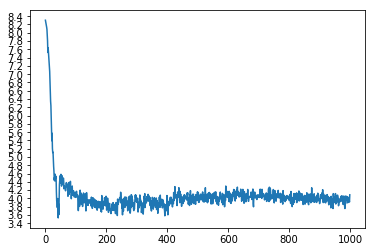

<Figure size 432x288 with 0 Axes>

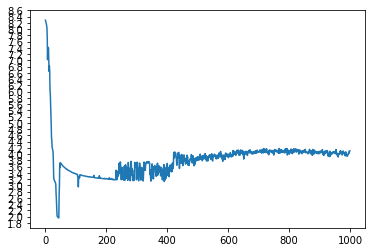

<Figure size 432x288 with 0 Axes>

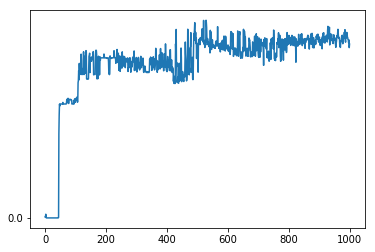

<Figure size 432x288 with 0 Axes>

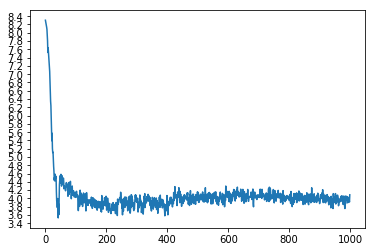

<Figure size 432x288 with 0 Axes>

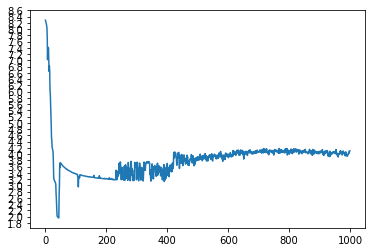

In [23]:
hidden_size = 256
encoder1 = EncoderRNN(len(english_vocab), hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, len(indo_vocab), dropout_p=0.1).to(device)

plot_losses, val_losses = trainIters(encoder1, attn_decoder1, 100000, print_every=100)

showPlot(plot_losses, 'train_plot.png')
showPlot(val_losses, 'validation_plot.png')

evaluateRandomly(encoder1, attn_decoder1)

output_words, attentions = evaluate(
    encoder1, attn_decoder1, "do you love me?")

## Check some translations

In [ ]:
# Load the best model 
#hidden_size = 1024
#encoder1 = EncoderRNN(len(english_vocab), hidden_size).to(device)
#attn_decoder1 = AttnDecoderRNN(hidden_size, len(indo_vocab), dropout_p=0.1).to(device)
#encoder1.load_state_dict(torch.load("./results/encoder-1800.pth"))
#encoder1.eval()

#attn_decoder1.load_state_dict(torch.load("./results/decoder-1800.pth"))
#attn_decoder1.eval()


In [24]:
print(translate("tom is playing with ball."))

print(translate("she is standing there ."))

print(translate("he is a bad man ."))

print(translate("he wants to sleep ."))

<s> tom tidak tidak . . . </s>
<s> tom tidak . . </s>
<s> aku tidak tidak . . . </s>
<s> aku tidak . . . </s>
